# Making predictions, aka how to use blobs.

As far as I can tell, there are two types of predictions:

- (a) predict (x,v) of the true state of the system at t
- (b) predict (x,v) of what a measurement would yield at approx t

How to do it:

- (a) is done by evaluating the forward model at t to get samples of (x,v)
- (b) is done by drawing a sample (t,x,v) from the likelihood for all given theta

Implementation:

- (a) can be implemented by returning a [blob](http://dan.iel.fm/emcee/current/user/advanced/#arbitrary-metadata-blobs) from the pdf containing the (x,v) at the desired ts.
- (b) is a bit harder.  I think it goes like this: for a given theta, draw a t_p with error sigma_t, evaluate fwd(theta, t_d)->(x,v). Draw an x_p, y_p with sigma_x,sigma-v.

  0.000004 seconds (148 allocations: 10.151 KB)


    +(AbstractArray, DataArrays.DataArray) at /home/mauro/.julia/v0.4/DataArrays/src/operators.jl:276
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /home/mauro/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.DataArray{T<:Any, 2})
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /home/mauro/.julia/v0.4/DataArrays/src/operators.jl:300
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /home/mauro/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.AbstractDataArray{T<:Any, 2})
before the new definition.


[Plots.jl] Initializing backend: pyplot



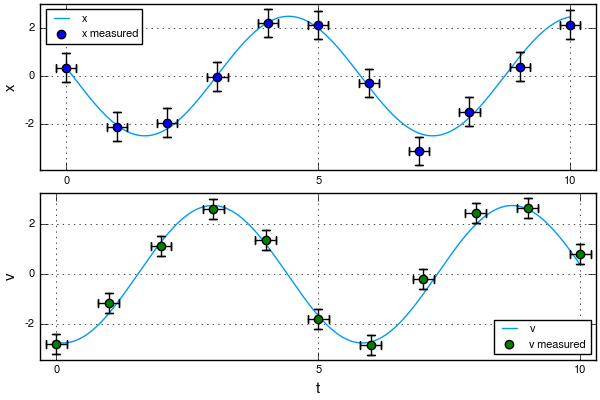

In [1]:
using NBInclude
nbinclude("bayesian-ex-base.ipynb")

using Plots,StatPlots # this works only up to StatPlots 9e665438 & on 0.5 of PyCall too (14 July 2016)
# choose to use the analytic or ODE-forward model
fwd! = [fwd_ana!, fwd_ode!][1]
@time 1 # warmup

# make the synthetic measurements
fac = 1
sigma_x = 0.3 *fac
sigma_v = 0.2 *fac
sigma_t = 0.1 *fac
const ts_measured, xv_measured, A, ω, ϕ, ts_true, xv_true = make_synthetic_measurements(theta_true = [2.5, 1.1, 3], # [A, ω, ϕ]
                                                                                        sigma_x=sigma_x,
                                                                                        sigma_v=sigma_v,
                                                                                        sigma_t=sigma_t)
@assert !all(ts_measured.==ts_true)

## Plot the measurements
plotmeasurements(ts_measured,xv_measured,A,ω,ϕ,sigma_x=sigma_x,sigma_v=sigma_v,sigma_t=sigma_t)

## Probabilistic model setup

Fitting parameters `[A,ω,ϕ,sigma_x,sigma_v,sigma_t,ts] = theta`

Predict (x,y) (a) and (b) at `ts_pred` times.

In [2]:
################
# Predict (x,y) (a) and (b) at these locations
ts_pred = [5.0, 8.5, 15, 30, 100, 1e4]
# I do this below by returning a blob of x,v values
# [x,v,x,v,...]

# helper functions:
function unpack_blob(blob::Vector, ts_pred)
    n = length(ts_pred)
    xv_a = blob[1:2n]
    xv_b = blob[2n+1:end]
    return xv_a,xv_b
end
function unpack_blob(blob::Matrix, ts_pred)
    n = length(ts_pred)
    ns = size(blob,2)
    xv_a,xv_b = zeros(2n,ns),zeros(2n,ns)
    for s=1:ns
        xv_a[:,s] = blob[1:2n,s]
        xv_b[:,s] = blob[2n+1:end,s]
    end
    return xv_a,xv_b
end

const fwdout = init_fwd(ts_measured) # Note, this will be modified in place
const fwdout_pred = init_fwd(ts_pred); # Note, this will be modified in place

varnames = vcat(["A","ω",  "ϕ",  "σ_x", "σ_v", "σ_t"], ["t$i" for i=1:length(ts_measured)])

getts(theta) = view(theta, 7:length(ts_measured)+6)

# Treat ts as measurements too
function loglikelihood(fwdout, ts, xv_measured, ts_measured, sigma_x,sigma_v,sigma_t)
    out = zero(err1(xv_measured[1], fwdout[1]))
    N = length(xv_measured)

    # Note the normalization term 1/2*log(2*pi*sigma^2) needs to
    # be included when sigma is also a fitting parameter.
    for i=1:2:N
        out -= err1(xv_measured[i], fwdout[i])/(sigma_x^2) + log(2*pi*sigma_x^2)
    end
    for i=2:2:N
        out -= err1(xv_measured[i], fwdout[i])/(sigma_v^2) + log(2*pi*sigma_v^2)
    end
    # treat time as measurements too
    for i=1:length(ts)
        out -= err1(ts_measured[i], ts[i])/(sigma_t^2) + log(2*pi*sigma_t^2)
    end
    return out/2
end

# Normal & uniform priors
logprior_A(A) = 0<=A ? 0.0 : -Inf # amplitude is positive
ω_max = 15.0
logprior_ω(ω) = 0<=ω<ω_max ? 0.0 : -Inf # ω is bounded
logprior_ϕ(ϕ) = 0<=ϕ<2*pi ? 0.0 : -Inf # ϕ is bounded

sigma_x_est = 0.2 # our prior estimate of sigma_x
sigma_est_sigma_x = 0.2 # our estimate of the std of sigma_x
logprior_sigma_x(sigma_x) = sigma_x<=0 ? -Inf : -(sigma_x-sigma_x_est)^2/(2*sigma_est_sigma_x^2)

sigma_v_est = 0.2 # our prior estimate of sigma_v
sigma_est_sigma_v = 0.2 # our estimate of the std of sigma_v
logprior_sigma_v(sigma_v) = sigma_v<=0 ? -Inf : -(sigma_v-sigma_v_est)^2/(2*sigma_est_sigma_v^2)

sigma_t_est = 0.05 # our prior estimate of sigma_t
sigma_est_sigma_t = 0.05 # our estimate of the std of sigma_t
logprior_sigma_t(sigma_t) = sigma_t<=0 ? -Inf : -(sigma_t-sigma_t_est)^2/(2*sigma_est_sigma_t^2)

# TODO: what about priors on ts?
# sum of priors for ts
function logpriors_ts(ts)
    out = 0.0
    for i=1:length(ts)
        out -= (ts[i]-ts_measured[i])^2/(2*sigma_t_est^2)
    end
    return out
end


logprior = (theta) -> (logprior_A(theta[1]) +
                       logprior_ω(theta[2]) +
                       logprior_ϕ(theta[3]) +
                       logprior_sigma_x(theta[4]) +
                       logprior_sigma_v(theta[5]) +
                       logprior_sigma_t(theta[6]) +
                       logpriors_ts(getts(theta))
                       );

## Blobs in the posterior

The posterior now also returns a blob (a arbitraty bit of data), which contains the needes samples for the predictions

In [3]:
function logposterior_blob(theta)
    # Closure over fwdout, fwdout_pred, xv_measured, ts_measured
    
    # calculate posterior density:
    A,ω,ϕ,sigma_x,sigma_v,sigma_t = theta
    ts = getts(theta)
    fwd!(fwdout, ts, A,ω,ϕ)
    logl = loglikelihood(fwdout, ts, xv_measured, ts_measured, sigma_x,sigma_v,sigma_t)
    density = logl + logprior(theta)
    # Calculate blob.  Note that if the forward model was more
    # expensive then this should be done more cleverly by only
    # evaluating it simultaneously at the ts_measured and ts_pred.
    np = length(ts_pred)
    blob = zeros(4*np)
    # (a) prediction
    fwd!(fwdout_pred, ts_pred, A,ω,ϕ)
    blob[1:2np] = fwdout_pred
    # (b) prediction
    ts_pred_s = randn(np)*sigma_t + ts_pred # t with errors
    fwd!(fwdout_pred, ts_pred_s, A,ω,ϕ) # fwd-model at those points
    for i=1:np
        # sample x and v
        blob[2np+2i-1] = randn()*sigma_x + fwdout_pred[2i-1]
        blob[2np+2i  ] = randn()*sigma_v + fwdout_pred[2i]
    end
    return density, blob
end;

## MCMC fitting

First define some parameters. Generally `_m` referes to variables connected to the Metropolis sampler, `_e` to the `emcee` sampler.

In [4]:
niter = 5*10^5 # number of MC steps
nthin = 10     # only store theta every so often
nburnin = niter÷3 # how much burn-in
nchains = 50 # number of chains used in the emcee sampler
niter_e = niter÷nchains # iterations in the emcee sampler reduced accordingly
nburnin_e = niter_e÷3;

In [5]:
#################
# Metropolis MCMC
#################

# Using a Gaussian proposal distribution.  Note, this needs to be
# symmetric for Metropolis!

sig = 0.002  # this needs tuning, accept_ratio of 1/4 is good, they say.
const sigma_ppdf = sig*ones(6+length(ts_measured))
sample_ppdf(theta) = [randn()*sigma_ppdf[i]+theta[i] for i=1:length(theta)]

theta_true = vcat([A, ω, ϕ, sigma_x, sigma_v, sigma_t], ts_measured);  # good IC
theta0 = vcat([2.1, 1.1, 1.1, 0.2, 0.2, 0.05], ts_measured); # decent IC

metropolis(logposterior_blob, sample_ppdf, theta0, niter=2, hasblob=true)
print("Metropolis: ")
@time thetas_m, accept_ratio_m, blobs_m = metropolis(logposterior_blob, sample_ppdf, theta0,
                                                     niter=niter, nthin=nthin, nburnin=nburnin, hasblob=true)
xv_a,xv_b = unpack_blob(blobs_m, ts_pred);
x_a,v_a = unpack_xv(xv_a);
print_results(thetas_m, accept_ratio_m, names=varnames, title="Metropolis", theta_true=theta_true)

Metropolis:   7.147187 seconds (84.57 M allocations: 1.747 GB, 3.11% gc time)
Metropolis
Ratio of accepted/total steps: 0.5772708454583091

var 	 err	median	 mean 	 mode 	 std
A 	 0.04 	 2.54 	 2.54 	 2.63 	 0.08
ω 	 0.01 	 1.09 	 1.09 	 1.08 	 0.01
ϕ 	 0.06 	 3.06 	 3.05 	 3.05 	 0.06
σ_x 	 0.02 	 0.32 	 0.33 	 0.42 	 0.06
σ_v 	 0.11 	 0.31 	 0.32 	 0.23 	 0.06
σ_t 	 0.09 	 0.01 	 0.02 	 0.0 	 0.01
t1 	 0.0 	 0.0 	 0.0 	 0.0 	 0.02
t2 	 0.0 	 1.0 	 1.0 	 1.0 	 0.02
t3 	 0.0 	 2.0 	 2.0 	 2.0 	 0.02
t4 	 0.0 	 3.0 	 3.0 	 3.0 	 0.02
t5 	 0.0 	 4.0 	 4.0 	 4.0 	 0.02
t6 	 0.0 	 5.0 	 5.0 	 5.0 	 0.02
t7 	 0.0 	 6.0 	 6.0 	 6.0 	 0.02
t8 	 0.0 	 7.0 	 7.01 	 7.0 	 0.02
t9 	 0.0 	 8.0 	 8.0 	 8.0 	 0.02
t10 	 0.0 	 9.0 	 9.0 	 9.0 	 0.02
t11 	 0.0 	 10.0 	 10.0 	 10.0 	 0.02



In [6]:
#################
# emcee MCMC
#################

emcee(logposterior_blob, (theta0, 0.1), niter=10, nchains=2, hasblob=true)
print("emcee:")
@time thetas_ec, accept_ratio_ec, blobs_ec = emcee(logposterior_blob, (theta0, 0.1),
                                               niter=niter_e, nthin=nthin, nchains=nchains, nburnin=nburnin_e, hasblob=true)
# When running this problem with IC far from the maximum, then emcee produces bad chains which are dropped:
thetas_e, accept_ratio_e, blobs_e = squash_chains(thetas_ec, accept_ratio_ec, blobs_ec, drop_low_accept_ratio=true)
print_results(thetas_e, accept_ratio_e, names=varnames, title="emcee", theta_true=theta_true)

emcee:  7.667618 seconds (88.01 M allocations: 1.979 GB, 3.44% gc time)
Dropping low accept-ratio chain 4
Dropping low accept-ratio chain 7
Dropping low accept-ratio chain 9
Dropping low accept-ratio chain 10
Dropping low accept-ratio chain 13
Dropping low accept-ratio chain 16
Dropping low accept-ratio chain 40
Dropping low accept-ratio chain 47
Dropping low accept-ratio chain 48
emcee
Ratio of accepted/total steps: 0.31753412329383535

var 	 err	median	 mean 	 mode 	 std
A 	 0.02 	 2.52 	 2.52 	 2.49 	 0.09
ω 	 0.01 	 1.09 	 1.09 	 1.09 	 0.01
ϕ 	 0.06 	 3.06 	 3.06 	 3.06 	 0.07
σ_x 	 0.03 	 0.33 	 0.34 	 0.29 	 0.07
σ_v 	 0.13 	 0.33 	 0.34 	 0.3 	 0.07
σ_t 	 0.08 	 0.02 	 0.02 	 0.01 	 0.01
t1 	 0.0 	 -0.0 	 -0.0 	 -0.0 	 0.02
t2 	 0.0 	 1.0 	 1.0 	 1.0 	 0.02
t3 	 0.0 	 2.0 	 2.0 	 2.0 	 0.02
t4 	 0.0 	 3.0 	 3.0 	 3.0 	 0.02
t5 	 0.0 	 4.0 	 4.0 	 4.0 	 0.02
t6 	 0.0 	 5.0 	 5.0 	 5.0 	 0.02
t7 	 0.0 	 6.0 	 6.0 	 6.0 	 0.02
t8 	 0.01 	 7.01 	 7.01 	 7.0 	 0.02
t9 	 0.0 	 8.0 	 


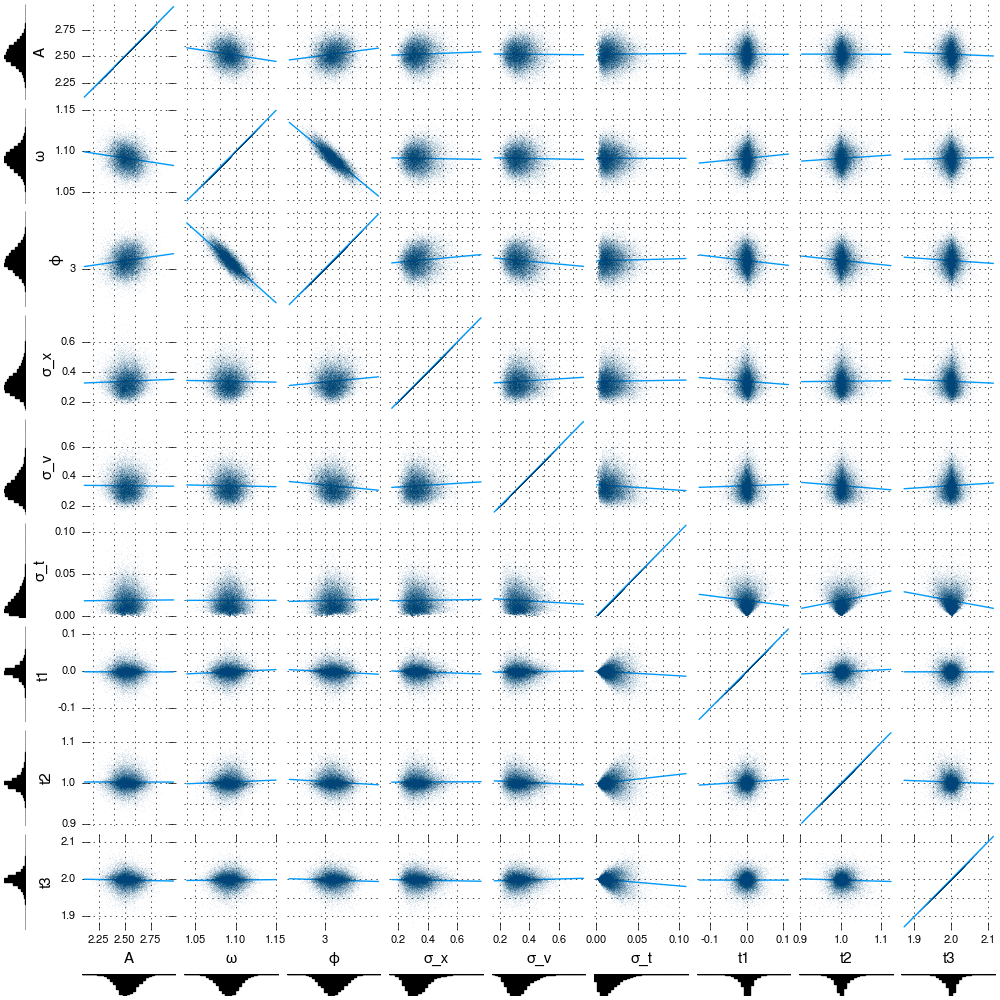

In [7]:
np = 9
cornerplot(thetas_e[1:np,:]', label=varnames[1:np], size=(1000,1000))

## Making predictions

The blobs returned the sampled $(x,y)$ pairs at the `ts_pred` times.  This is plotted below with the violines.  The darker inner violin is (a), i.e. denisty of the true `(x,y)` and the outer violin is the density estimate of `(x_measured, y_measured)` if a measurment where performed there. The 3x2 plots on the right are at times much after the measurements, thus were plotted detached.


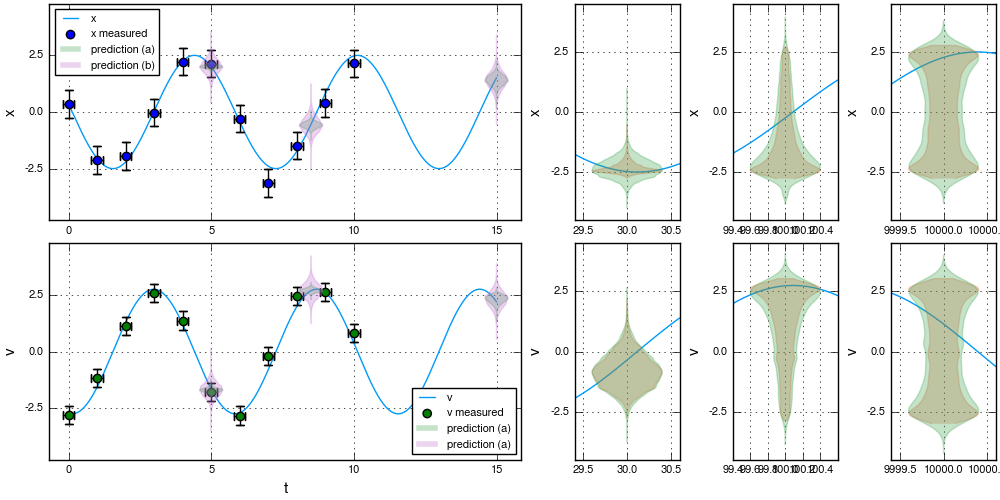

In [8]:
plot_violin(ts_measured, xv_measured, ts_pred, xv_a, xv_b, A, ω, ϕ;
            sigma_x=sigma_x, sigma_v=sigma_v, sigma_t=sigma_t, 
            t_plot=0:0.01:15, pred_inds=1:3, pred_inds_sep=4:6, 
            size=(1000,500))